In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE

In [2]:
all_files = glob.glob("roll_data/*-steal_attempt.csv")

df = pd.concat((pd.read_csv(f, dtype={"stadium_id": "string", "is_strike": "boolean"}) for f in all_files), ignore_index=True)

season = 13
df = df[df["season"] == season]
len(df)

55082

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass  # traveling just doesn't do anything on pitchers?
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass  # growth doesn't do anything on pitchers either
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    attrs = ""
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        if row["top_of_inning"]:
            # is this actually 0.035 instead of 0.05?
            mul += 0.35
    if "GROWTH" in btm:
        # is this actually 0.035 instead of 0.05?
        mul += min(0.05, 0.05 * (row["day"] / 99))
        # pass
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "power" attrs
        mul += 1.0
        attrs = "batter_musclitude, batter_divinity, batter_ground_friction"
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # todo: make this work if there's also, like, Overperforming active
        # it only should apply to "speed" attrs
        # doing 80% because of evidence from the Spin Attack blessing that "speed"
        # boosts laserlikeness 80% of what it says the total boost is?
        mul += 0.80
        attrs = "batter_musclitude, batter_laserlikeness, batter_ground_friction, batter_continuation"
    if "ON_FIRE" in bm:
        # todo: handle
        # test "+125% multiplier"
        mul += 1.25
        # pass
    # NVGs real??? eclipse weather, special case for Sutton Dreamy
    # surely this will not break from scattering, right? (It totally will)
    if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        mul += 0.50
    return mul, attrs

def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == 18 and str(row["baserunner_count"]) > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        mul += 0.50
    return mul


In [4]:
# df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df[["batter_mul", "batter_mul_attrs"]] = df.apply(get_batter_mul, axis=1, result_type="expand")
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [5]:
# df["baserunner_n"] = [int(np.floor(len(x) / 40)) for x in df.loc[:, "baserunner_count"]]

df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

In [6]:
for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    # had to do all this to make chunky and smooth work correctly
    df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["batter_mul"] * (1 + 0.2 * x["batter_vibes"])
                                  if (x["batter_mul_attrs"] == "") or (attr in x["batter_mul_attrs"])
                                  else x[attr] * (1 + 0.2 * x["batter_vibes"]),
                                  axis=1)
    # df[attr + "_mul_vibe"] = df[attr] * df["batter_mul"] * (1 + 0.2 * df["batter_vibes"])

In [7]:
df = df.copy()
for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])
    #                           if (x["pitcher_mul_attrs"] == "") or (attr in x["pitcher_mul_attrs"])
    #                           else x[attr] * (1 + 0.2 * df["pitcher_vibes"]),
    #                           axis=1)
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

In [294]:
if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        # df[attr+"_mul_vibe"] = df.apply(lambda x: x[attr] * x["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])
        #                       if (x["fielder_mul_attrs"] == "") or (attr in x["fielder_mul_attrs"])
        #                       else x[attr] * (1 + 0.2 * df["fielder_vibes"]),
        #                       axis=1)
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])

df["cold_runners"] = df["pitcher_coldness_mul_vibe"] * (0 + df["baserunner_count"])
df["laser_thirst"] = df["batter_laserlikeness_mul_vibe"] * df["batter_base_thirst_mul_vibe"]
df["thirstsq"] = df["batter_base_thirst_mul_vibe"] * df["batter_base_thirst_mul_vibe"]
df["lasersq"] = df["batter_laserlikeness_mul_vibe"] * df["batter_laserlikeness_mul_vibe"]
df["explaser"] = np.exp(df["batter_laserlikeness_mul_vibe"])
df["sinlaser"] = np.sin(df["batter_laserlikeness_mul_vibe"])
# df["laser3"] = df["lasersq"] * df["batter_laserlikeness_mul_vibe"]
# df["laser4"] = df["laser3"] * df["batter_laserlikeness_mul_vibe"]
# df["laser5"] = df["laser4"] * df["batter_laserlikeness_mul_vibe"]
df = df.copy()

In [295]:
df.groupby("event_type").size().sort_values(ascending=False)[0:15]

event_type
StealAttempt0    27686
StealAttempt1    14307
StealAttempt2    13089
dtype: int64

In [296]:
dfc = df[df["event_type"] == "StealAttempt0"].copy()
# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
# for exclude_mod in ["FLINCH", "O_NO", "ON_FIRE", "GROWTH", "TRAVELING"]:
# for exclude_mod in ["SPICY", "ON_FIRE"]:
# dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
#  dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


dfc = dfc[(dfc["pitcher_mul"] == 1) & (dfc["batter_mul"] == 1) & (dfc["fielder_mul"] == 1)]

# dfc = dfc[dfc['stadium_id'].isna()]

len(dfc)

20190

In [348]:
X = dfc[
    [
        "roll",
        "passed",
        # "batter_base_thirst_mul_vibe",
        # "batter_laserlikeness_mul_vibe",
        "pitcher_watchfulness_mul_vibe",
        # "pitcher_anticapitalism_mul_vibe",
        # "pitcher_coldness_mul_vibe",
        "laser_thirst",
        # "explaser",
        # "sinlaser",
        # "lasersq",
        # "laser3",
        # "laser4",
        # "laser5",
        # "thirstsq",
        # "cold_runners",
        # "fielder_omniscience_mul_vibe",
        # 'fielder_tenaciousness_mul_vibe',
        "fielder_watchfulness_mul_vibe",
        # "fielder_watchfulness",
        # "fielder_anticapitalism_mul_vibe",
        # 'fielder_chasiness_mul_vibe',
        # "ballpark_grandiosity",
        # 'ballpark_fortification',
        # "ballpark_obtuseness",
        # 'ballpark_ominousness',
        "ballpark_inconvenience",
        # "ballpark_viscosity",
        # "ballpark_forwardness",
        'ballpark_elongation',
        # 'ballpark_mysticism',
        # 'ballpark_filthiness',
    ]
]
# X = X[X['roll'] < 0.85]

y = X["passed"]
X = X.drop("passed", axis=1)

In [349]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

# # trainedsvm = svm.SVC(kernel='linear').fit(X, y)
# trainedsvm = svm.LinearSVC(dual=False, max_iter=100000).fit(X, y)
# predictionsvm = trainedsvm.predict(X)
# print(confusion_matrix(y,predictionsvm))
# print(classification_report(y,predictionsvm))

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=1000000, tol=1e-10).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
print(confusion_matrix(y, predictionsvm))
print(classification_report(y, predictionsvm))
print(trainedsvm.score(X2, y))

[[19238    52]
 [   77   823]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     19290
        True       0.94      0.91      0.93       900

    accuracy                           0.99     20190
   macro avg       0.97      0.96      0.96     20190
weighted avg       0.99      0.99      0.99     20190

0.9936106983655275


In [350]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]

intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
print(intercept_scaled)
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[-0.07655228]


[(1.0, 'roll'),
 (-0.13874919102487646, 'laser_thirst'),
 (0.05912713321015933, 'pitcher_watchfulness_mul_vibe'),
 (0.05576143922253287, 'ballpark_elongation'),
 (0.027670731397518585, 'ballpark_inconvenience'),
 (0.021151587926087765, 'fielder_watchfulness_mul_vibe')]

## Best formulas so far

[0.07655228]
(-0.05912713321015933, 'pitcher_watchfulness_mul_vibe')
(0.13874919102487646, 'laser_thirst')
(-0.021151587926087765, 'fielder_watchfulness_mul_vibe')
(-0.027670731397518585, 'ballpark_inconvenience')
(-0.05576143922253287, 'ballpark_elongation')


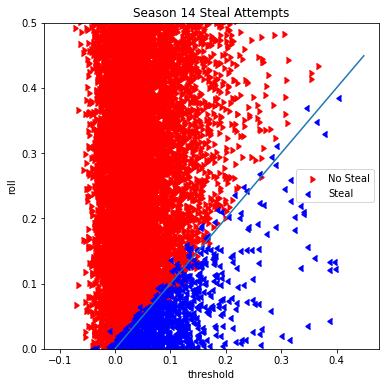

In [351]:
# dfc["threshold"] = 0.315 - (
#     -0.10 * dfc["batter_thwackability_mul_vibe"]
#     + 0.08 * dfc["pitcher_unthwackability_mul_vibe"]
#     + 0.07 * dfc["fielder_omniscience_mul_vibe"]
# )  # this works for season 12 and 13 without ballparks

# this will use the fit values
dfc["threshold"] = -intercept_scaled[0]
print(-intercept_scaled)
for pair in zip(-np.array(coef_list), X.columns):
    if pair[1] != "roll":
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]


y_val = "roll"
x_val = "threshold"
# x_val = "batter_watchfulness_mul_vibe"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="No Steal",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Steal",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
ax.set_title(f"Season {season+1} Steal Attempts")
# ax.set_xlim(0.484, 0.499)
ax.set_ylim(0, 0.5)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

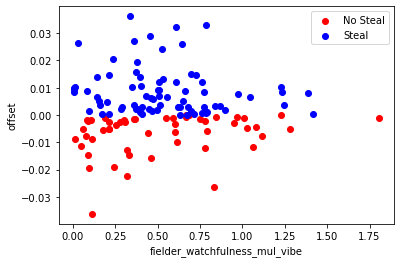

In [352]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]

fig, ax = plt.subplots(1)
x_val = "threshold"
x_val = "fielder_watchfulness_mul_vibe"
# x_val = "lasersq"
ax.scatter(
    outliers[~outliers["passed"]][x_val],
    outliers[~outliers["passed"]]["offset"],
    color="red",
    label="No Steal",
)
ax.scatter(
    outliers[outliers["passed"]][x_val],
    outliers[outliers["passed"]]["offset"],
    color="blue",
    label="Steal",
)
ax.set_xlabel(x_val)
ax.set_ylabel("offset")
ax.legend()

In [353]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
table = outliers[
    [
        "passed",
        "offset",
        "roll",
        "threshold",
        # "event_type",  # "home_score", "away_score", "top_of_inning", "inning",
        "pitcher_mul",
        "batter_mul",
        "fielder_mul",  # "baserunner_count",
        # "batter_vibes", "pitcher_vibes",
        "laser_thirst",
        "pitcher_watchfulness_mul_vibe",
        "fielder_watchfulness_mul_vibe",
        "ballpark_inconvenience",
        "batter_name",
        "pitcher_name",
        "fielder_name",
        "batter_mods",
        "pitcher_mods",
        "fielder_mods",
        "batting_team_mods",
        "pitching_team_mods",
        "season",
        "day",
        "game_id",
        "play_count",
        # "fielder_roll",
    ]
]
print(len(table))
table.sort_values("offset", ascending=False)#[0:10]

129


,passed,offset,roll,threshold,pitcher_mul,batter_mul,fielder_mul,laser_thirst,pitcher_watchfulness_mul_vibe,fielder_watchfulness_mul_vibe,ballpark_inconvenience,batter_name,pitcher_name,fielder_name,batter_mods,pitcher_mods,fielder_mods,batting_team_mods,pitching_team_mods,season,day,game_id,play_count
128455,True,0.036149,0.000184,-0.035965,1.0,1.0,1.0,0.027196,1.176318,0.335918,0.466335,Bonk Jokes,Ruslan Greatness,Lang Richardson,NaN,FRIEND_OF_CROWS,NaN,O_NO,AFFINITY_FOR_CROWS,13,104,bf090bfc-0b4b-4654-bd85-f2ec3123341d,128
113554,True,0.032880,0.028028,-0.004852,1.0,1.0,1.0,0.445086,1.495249,0.785549,0.414432,Scratch Deleuze,Gerund Pantheocide,Stijn Strongbody,NaN,NaN,SWIM_BLADDER,BOTTOM_DWELLER,NaN,13,36,6b9835ed-8454-41c3-ad57-e6db766fadea,12
101626,True,0.032069,0.136149,0.104080,1.0,1.0,1.0,1.095403,1.186304,0.610490,0.681991,Aldon Cashmoney,Enid Marlow,Scratch Deleuze,SPICY;EGO1,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,BOTTOM_DWELLER,13,18,686aa24f-4f10-42a2-95d2-a50d679fd74d,245
7437,True,0.029116,0.000576,-0.028540,1.0,1.0,1.0,0.038572,0.940037,0.454521,0.602586,Oliver Mueller,Mindy Kugel,Adelaide Judochop,NaN,NaN,NaN,PARTY_TIME,MAINTENANCE_MODE;PARTY_TIME,13,88,0923b3fa-be73-4e3d-a7db-d423dc7e18ac,212
127817,True,0.027250,0.187810,0.160560,1.0,1.0,1.0,1.199111,0.484959,0.359714,0.505260,Aldon Cashmoney,Val Hitherto,Engine Eberhardt,SPICY;EGO2,NaN,NaN,FIREPROOF;SEALANT;AMBUSH,NaN,13,102,88596964-df34-4d81-996e-bce32b41ac01,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105504,False,-0.019112,0.089067,0.108179,1.0,1.0,1.0,0.894883,0.861668,0.240852,0.426239,Pedro Davids,Doc Anice,Yusef Puddles,FLINCH,TRIPLE_THREAT,NaN,CARCINIZATION;UNHOLEY,AFFINITY_FOR_CROWS,13,22,5aee3e80-6285-457d-aa81-32fd4c637a56,291
7246,False,-0.019455,0.123543,0.142998,1.0,1.0,1.0,1.006718,0.466471,0.094312,0.459210,Kline Greenlemon,Felix Garbage,Winnie Mccall,NaN,NaN,NaN,NaN,BIRD_SEED,13,88,bbcb3c19-82cb-4350-9666-cdcf3df8dd89,128
120377,False,-0.022319,0.099297,0.121616,1.0,1.0,1.0,0.860336,0.364109,0.318188,0.512710,Pedro Davids,Cornelius Games,Simon Haley,FLINCH,WILD;PERK,FLINCH,CARCINIZATION;UNHOLEY,TRAVELING,13,43,e751d84a-49a4-4b2d-b234-0838d077b0e9,50
101249,False,-0.026301,0.071256,0.097557,1.0,1.0,1.0,0.979316,0.973806,0.835037,0.466335,Tot Fox,Curry Aliciakeyes,Bevan Wise,FLINCH,OVERUNDER,NaN,CARCINIZATION;UNHOLEY,O_NO,13,18,800c2e8d-1b3a-4c92-8e98-b2ae3813775e,132


In [327]:
# outliers.sort_values('roll', ascending=True).style.hide()
dfc.groupby("fielder_name").size().sort_values(ascending=False)[0:5]

fielder_name
Basilio Mason      192
Basilio Fig        191
Valentine Games    185
Eduardo Woodman    182
Kaz Fiasco         177
dtype: int64

In [328]:
dfc.corr()["offset"].sort_values()[0:10]

passed                          -0.373477
threshold                       -0.188566
laser_thirst                    -0.176084
lasersq                         -0.151750
explaser                        -0.151741
laser3                          -0.148070
batter_laserlikeness_mul_vibe   -0.146644
laser4                          -0.140539
runner_on_first_laserlikeness   -0.137732
batter_laserlikeness            -0.137732
Name: offset, dtype: float64

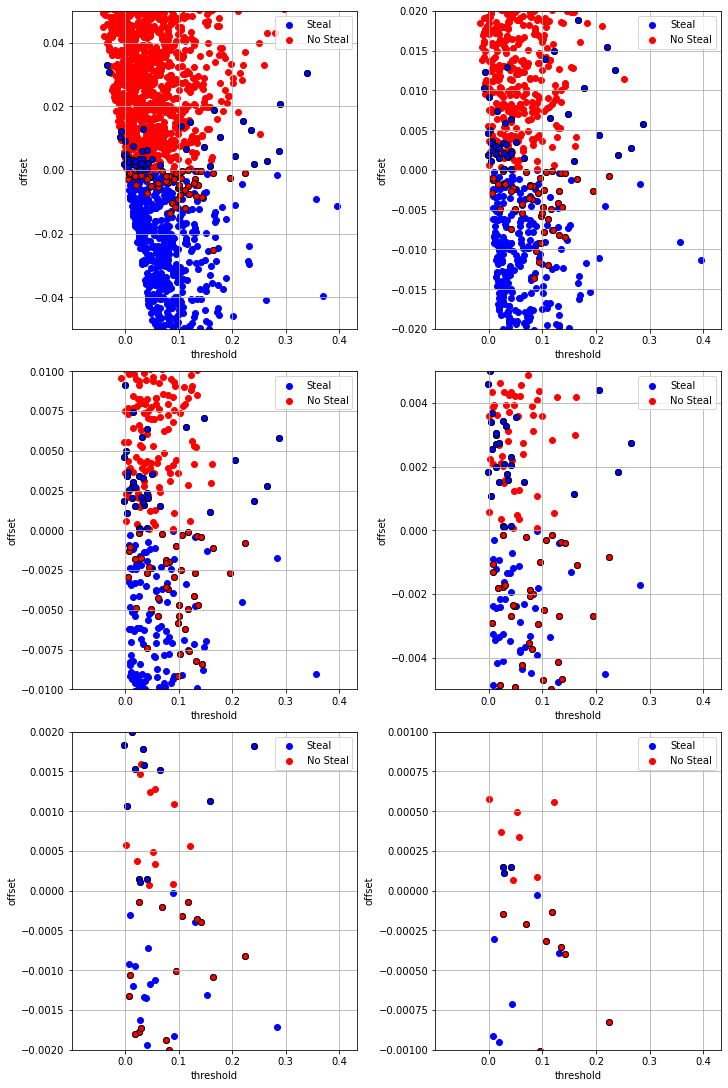

In [329]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Steal",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="No Steal",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("hit_out_fit_offsets.png", facecolor='white')